# ***AMATRICE-VISSO-NORCIA 2016-2017*** seismic sequence (Central Appennines)

#### The aim is to ***create a seismic catalog using new artificial intelligence methods***, particularly ***PhaseNet*** (Zhu et al., 2019) and the ***Seisbench*** platform, which contains training datasets and other deep learning models for picking.

##### Let's start with the first task:
##### Download the INGV (Istituto Nazionale di Geofisica e Vulcanologia) seismic data selecting a specific area. 


##### The parameters to be specified will be:
##### 1. Directory of the experiment;
##### 2. Stations data (e.g., channels, network ....);
##### 3. Minimum and maximum latitude and longitude to define the extraction rectangle; 
##### 4. Time interval (for convenience only one day-October 30, 2016).

In [1]:
#upload the libreries
from obspy import UTCDateTime, Stream, read
from obspy.clients.fdsn import Client
import os
import csv
import glob
import random
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime

In [10]:
# === config parameters ===
base_dir = "/Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE"
root_dir = os.path.join(base_dir, "waveforms")
inventory_dir = os.path.join(base_dir, "inventory")
log_file_path = os.path.join(base_dir, "download_log.txt")
os.makedirs(root_dir, exist_ok=True)
os.makedirs(inventory_dir, exist_ok=True)
network = "*"  # all the network
channel = "HH?,EH?"  #channel type
minlatitude = 42.4
maxlatitude = 43.2
minlongitude = 12.8
maxlongitude = 13.6
starttime = UTCDateTime("2016-10-30")
endtime = UTCDateTime("2016-10-31")

In [11]:
# === define client ===
fdsn_clients = [Client("INGV"), Client("IRIS")]

In [12]:
station_metadata = []

In [13]:
# === Open log file ===
log_file = open(log_file_path, "w")

In [14]:
# === write log file for debug ===
def log(message):
    print(message)
    log_file.write(message + "\n")

In [15]:
# === Let's download waveforms and stations xml ===
def try_with_clients(method_name, *args, **kwargs):
    for client in fdsn_clients:
        try:
            method = getattr(client, method_name)
            return method(*args, **kwargs)
        except Exception as e:
            log(f"[!] {client.base_url} failed for {method_name}: {e}")
    raise RuntimeError(f"All clients failed for {method_name}.")
    
def month_range(start, end):
    current = start
    while current < end:
        next_month = (current + timedelta(days=32)).replace(day=1)
        yield current, min(next_month, end)
        current = next_month


overall_start = datetime.now()
log(f"=== Download started at {overall_start.strftime('%Y-%m-%d %H:%M:%S')} ===")
for t0, t1 in month_range(starttime, endtime):
    log(f"\n>> Downloading from {t0.date} to {t1.date}")

    try:
        inventory = try_with_clients("get_stations", starttime=t0, endtime=t1,
                                        minlatitude=minlatitude, maxlatitude=maxlatitude,
                                        minlongitude=minlongitude, maxlongitude=maxlongitude,
                                        level="channel", network=network, channel=channel)

        for net in inventory:
            for sta in net:
                net_code = net.code
                sta_code = sta.code
                year = str(t0.year)
                components = []
                sensor = ""
                gain = ""

                for chan in sta:
                    comp = chan.code
                    components.append(comp)

                    try:
                        if chan.response and not sensor:
                            sensor = chan.sensor.description
                            gain = chan.response.instrument_sensitivity.value
                    except:
                        pass

                    try:
                        st = try_with_clients("get_waveforms", network=net_code, station=sta_code, location="*", channel=comp,
                                                  starttime=t0, endtime=t1)

                        # === Build output path and filename
                        day_of_year = t0.strftime('%j')
                        folder = os.path.join(root_dir, year, net_code, sta_code, f"{comp}.D")
                        os.makedirs(folder, exist_ok=True)

                        filename = f"{net_code}.{sta_code}..{comp}.D.{year}.{day_of_year}"
                        filepath = os.path.join(folder, filename)

                        st.write(filepath, format="MSEED")
                        log(f"Saved: {filepath}")
                    except Exception as e:
                        log(f"  [!] Error downloading {net_code}.{sta_code}.{comp}: {e}")

                # === Save StationXML inventory for this station
                try:
                    single_inv = inventory.select(network=net_code, station=sta_code)
                    xml_filename = f"{net_code}.{sta_code}.xml"
                    xml_path = os.path.join(inventory_dir, xml_filename)
                    single_inv.write(xml_path, format="STATIONXML")
                    log(f"StationXML saved: {xml_path}")
                except Exception as e:
                    log(f"  [!] Error saving StationXML for {net_code}.{sta_code}: {e}")

                # === Save station metadata
                row = {
                    "network": net_code,
                    "station": sta_code,
                    "latitude": sta.latitude,
                    "longitude": sta.longitude,
                    "elevation": sta.elevation,
                    "start_date": str(sta.start_date) if sta.start_date else "",
                    "end_date": str(sta.end_date) if sta.end_date else "",
                    "components": ",".join(sorted(set(components))),
                    "sensor_description": sensor,
                    "instrument_gain": gain
                }
                station_metadata.append(row)

    except Exception as e:
        log(f"[!] Error fetching stations: {e}")

# === Save station metadata to CSV ===
csv_path = os.path.join(base_dir, "stations.csv")
fieldnames = list(station_metadata[0].keys()) if station_metadata else []

with open(csv_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for row in station_metadata:
        writer.writerow(row)

log(f"\n Station metadata saved to: {csv_path}")

=== Download started at 2025-04-14 14:51:54 ===

>> Downloading from 2016-10-30 to 2016-10-31
Saved: /Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/waveforms/2016/3A/MZ08/EHE.D/3A.MZ08..EHE.D.2016.304
Saved: /Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/waveforms/2016/3A/MZ08/EHN.D/3A.MZ08..EHN.D.2016.304
Saved: /Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/waveforms/2016/3A/MZ08/EHZ.D/3A.MZ08..EHZ.D.2016.304
StationXML saved: /Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/inventory/3A.MZ08.xml
Saved: /Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/waveforms/2016/3A/MZ10/EHE.D/3A.MZ10..EHE.D.2016.304
Saved: /Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/waveforms/2016/3A/MZ10/EHN.D/3A.MZ10..EHN.D.2016.304
Saved: /Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/waveforms/2016/3A/MZ10/EHZ.D/3A.MZ10..EHZ.D.2016.304
StationXML saved: /Users/rossella.fonzetti/W


>> Looking for a station to plot...
>> Plotting station: CAMP (IV)
Plot saved to: /Users/rossella.fonzetti/WORK/EGU2025/TUTORIAL_EPOS/TEST_AMATRICE/waveform_plot_CAMP.pdf


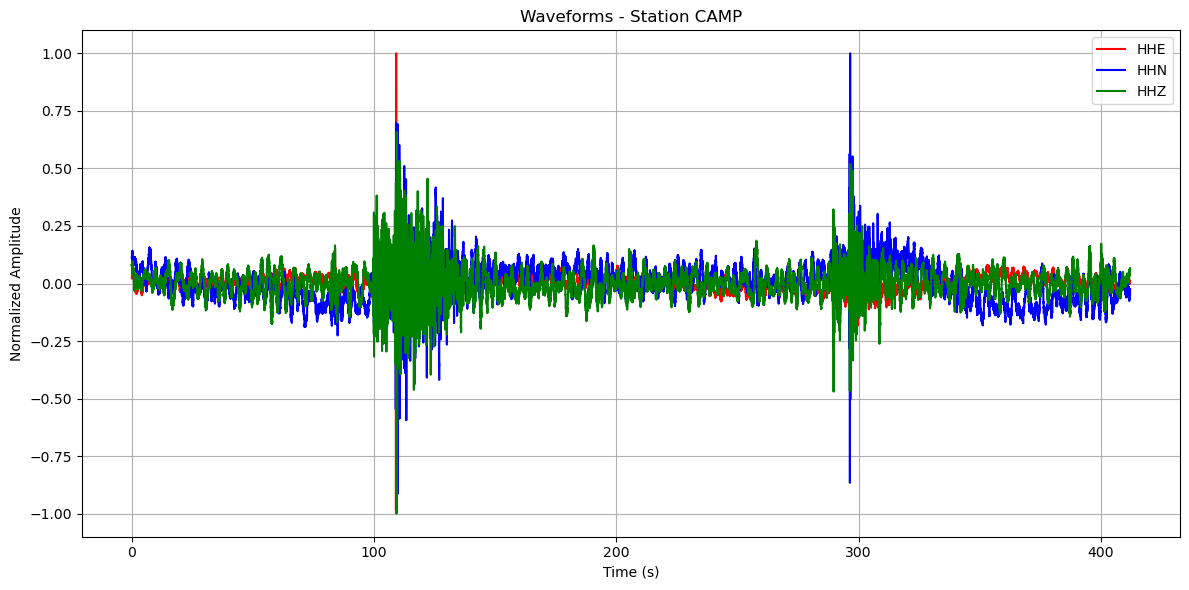

===Download finished at 2025-04-14 15:00:05===
Total duration: 0:08:11.143781


In [16]:
# === Plot 3 components from a random station ===
log("\n>> Looking for a station to plot...")
candidates = []
for year_path in os.listdir(root_dir):
    yp = os.path.join(root_dir, year_path)
    if not os.path.isdir(yp):
        continue
    for net in os.listdir(yp):
        np = os.path.join(yp, net)
        if not os.path.isdir(np):
            continue
        np = os.path.join(yp, net)
        for sta in os.listdir(np):
            sp = os.path.join(np, sta)
            if not os.path.isdir(sp):
                continue
            channels = os.listdir(sp)
            if all(f"{c}.D" in channels for c in ["HHZ", "HHN", "HHE"]):
                candidates.append((yp, net, sta))

if candidates:
    yp, net, sta = random.choice(candidates)
    log(f">> Plotting station: {sta} ({net})")

    stream = Stream()
    for comp, color in zip(["HHZ", "HHN", "HHE"], ["red", "blue", "green"]):
        folder = os.path.join(yp, net, sta, f"{comp}.D")
        files = sorted(glob.glob(os.path.join(folder, f"{net}.{sta}..{comp}.D.*")))
        if files:
            tr = read(files[0])[0]
            stream += tr

    stream.merge(method=1)
    stream.detrend("linear")
    stream.normalize()

    plt.figure(figsize=(12, 6))
    for tr, color in zip(stream, ["red", "blue", "green"]):
        plt.plot(tr.times(), tr.data, label=tr.stats.channel, color=color)

    plt.title(f"Waveforms - Station {sta}")
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized Amplitude")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plot_path = os.path.join(base_dir, f"waveform_plot_{sta}.pdf")
    plt.savefig(plot_path.replace('.png', '.pdf'), format='pdf', dpi=300)
    log(f"Plot saved to: {plot_path.replace('.png', '.pdf')}")
    plt.show()
else:
    log("No complete 3-component station found for plotting.")


overall_end = datetime.now()
log(f"===Download finished at {overall_end.strftime('%Y-%m-%d %H:%M:%S')}===")
log(f"Total duration: {str(overall_end - overall_start)}")
# === Close log file ===
log_file.close()